# Fit using sqrt and log

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 \sqrt{-\ln(1-x*a_2)} $$ 

In [3]:
def model_function(x: float,a1: float,a2: float):
    return a1*np.sqrt(-np.log(1-a2*x))

In [4]:
def get_extrapol_function(model_function,a1,a2):
    def extrapol_funct(x):
        return model_function(x,a1,a2)
    return extrapol_funct

## Read files

In [5]:
data_path = Path("../../../data/").resolve()
file = 'all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [6]:
df_all_tc

,1/nv,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [7]:
df_params = pd.DataFrame(index=["a1","a2"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

[0.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545454 0.04347826 0.04166667
 0.04       1.        ] [0.         0.6627212  0.50538593 0.42570714 0.37581216 0.34108253
 0.31510535 0.29499928 0.27861712 0.26505244 0.25362409 0.24383562
 0.2353144  0.22777345 0.22105832 0.215085   0.20965365 0.20476194
 0.20029922 0.19617411 0.19238246 0.18888646 0.18562053 0.18260146
 0.17975472 1.19968   ]


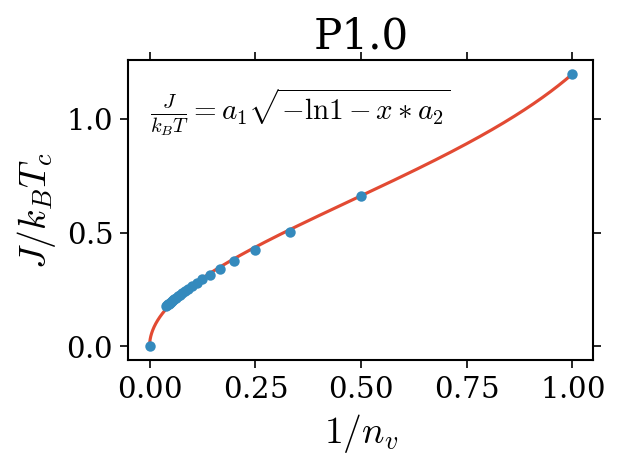

a1: 0.9095358201995817
a2: 0.823943352389555
Extrapolation:
-0.0 at 1/nv=0
1.198707990478174 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.68029698 0.52828397 0.45076787 0.40233737 0.36852339 0.34313569
 0.32335518 0.30733428 0.29398248 0.28271528 0.27300613 0.26453864
 0.25706392 0.25038224 0.24440318 0.23899408 0.23409924 0.22959455
 0.22547594 0.22169406 0.21816129 0.21484725 0.2118029  0.20893609
 1.19968   ]


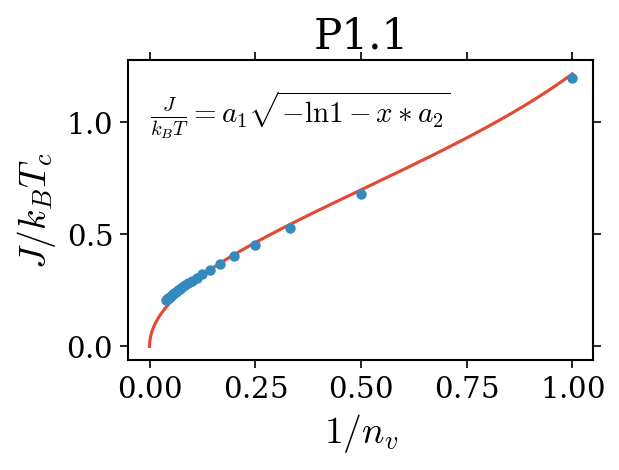

a1: 0.9999999999999999
a2: 0.7721112752449139
Extrapolation:
-0.0 at 1/nv=0
1.2160994278768191 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.70015005 0.54641946 0.4728325  0.42996963 0.39676535 0.37243076
 0.35305278 0.33748248 0.32450856 0.31345226 0.30402495 0.29568106
 0.2883911  0.28185887 0.27593458 0.27059888 0.26577508 0.26132227
 0.25725101 0.25344842 0.2500002  0.24668796 0.24367963 0.24080291
 1.19968   ]


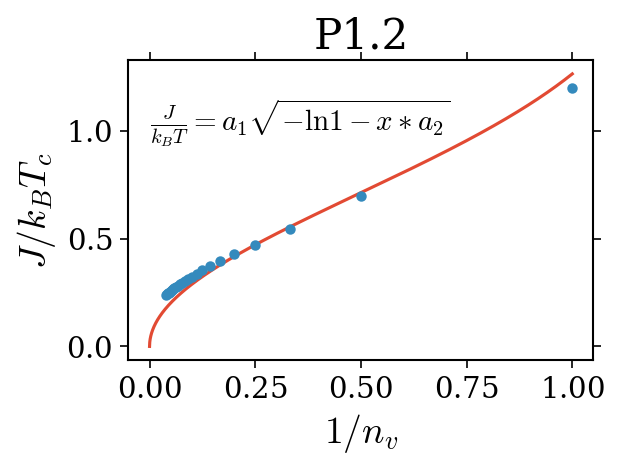

a1: 0.9999999999999999
a2: 0.7983582147727682
Extrapolation:
-0.0 at 1/nv=0
1.2654100111306787 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.71702843 0.57453923 0.50126452 0.45668793 0.42472068 0.401683
 0.38383649 0.3687956  0.35643392 0.34574783 0.33664995 0.32867694
 0.32157725 0.31516551 0.30950675 0.30435268 0.29969072 0.29536324
 0.29140134 0.28767541 0.2843088  0.28110767 0.27814305 0.27535238
 1.19968   ]


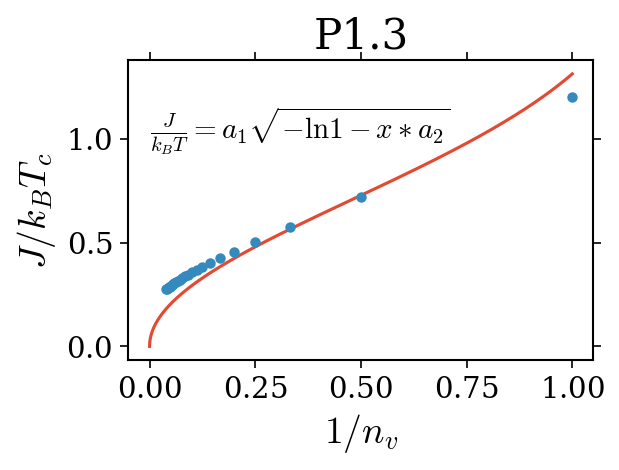

a1: 0.9999999999999999
a2: 0.8211866846987207
Extrapolation:
-0.0 at 1/nv=0
1.3120262758993837 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.73486649 0.59715338 0.52828397 0.48530684 0.45516705 0.43289128
 0.41538149 0.4013332  0.38949672 0.37939023 0.3706319  0.36307201
 0.35643392 0.35033373 0.34494491 0.34003441 0.33558601 0.33142354
 0.32770847 0.32418259 0.32091511 0.31787424 0.31505749 0.31239334
 1.19968   ]


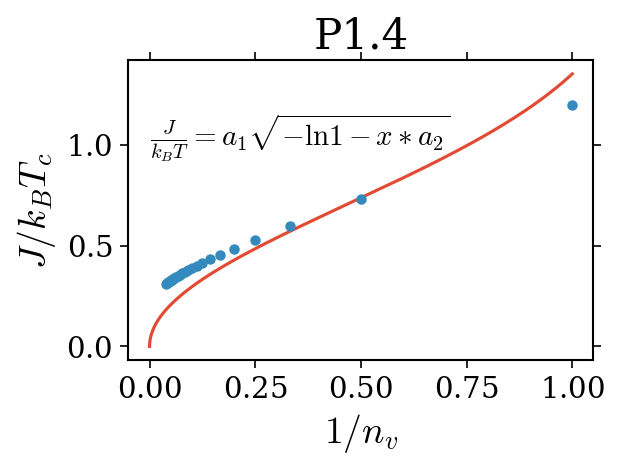

a1: 0.9999999999999999
a2: 0.8402099388905645
Extrapolation:
-0.0 at 1/nv=0
1.3542135885431785 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.7517265  0.61958081 0.55531776 0.51276532 0.48657308 0.46301963
 0.44787222 0.43456109 0.42354645 0.41412098 0.40590918 0.39898645
 0.39267217 0.38704066 0.38194687 0.37751633 0.37323194 0.36944741
 0.36597197 0.36276352 0.35966093 0.3568901  0.35420635 0.35171394
 1.19968   ]


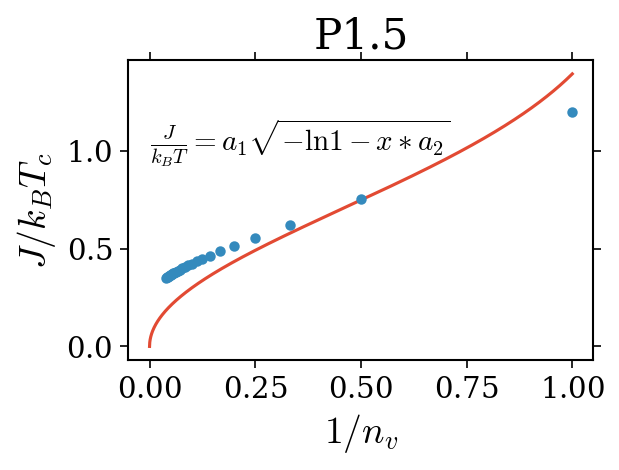

a1: 0.9999999999999999
a2: 0.8560638403120292
Extrapolation:
-0.0 at 1/nv=0
1.3922591041931012 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.77016848 0.64279299 0.58026805 0.54167053 0.51554311 0.49562125
 0.48046004 0.46836746 0.45814682 0.44959368 0.44206889 0.43571733
 0.42999685 0.42495329 0.42033975 0.41626528 0.41257384 0.40904366
 0.40595735 0.40295176 0.40015841 0.39770517 0.39529707 0.39307047
 1.19968   ]


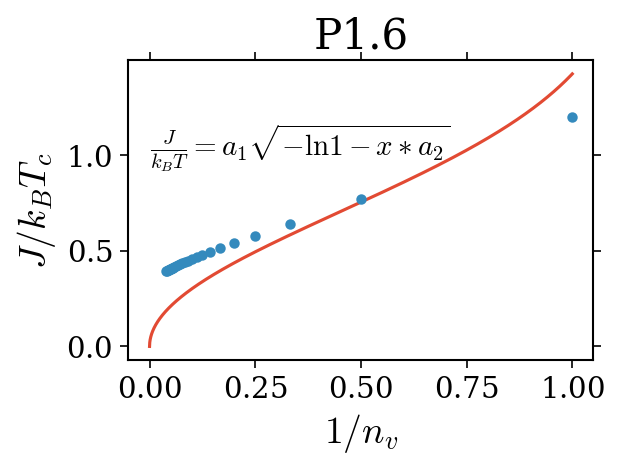

a1: 0.9999999999999999
a2: 0.8694327751835335
Extrapolation:
-0.0 at 1/nv=0
1.4268381310300955 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.78670254 0.66529945 0.60632809 0.56995367 0.54570368 0.52774054
 0.51361184 0.50257795 0.49349084 0.4855889  0.47905453 0.47324009
 0.46836746 0.46372018 0.45975351 0.4560911  0.45277333 0.44974731
 0.44697051 0.4444083  0.44203225 0.44000784 0.43788854 0.43594277
 1.19968   ]


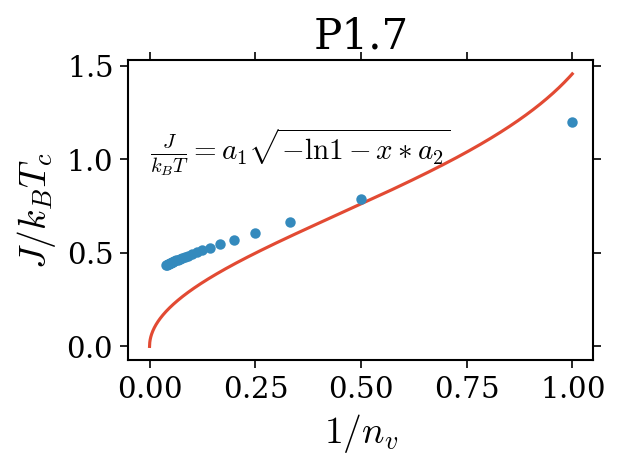

a1: 0.9999999999999999
a2: 0.8806456098257149
Extrapolation:
-0.0 at 1/nv=0
1.4579636973674144 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.80344138 0.6871691  0.63134611 0.59882219 0.57486374 0.56016388
 0.54688752 0.53684763 0.52853085 0.52179454 0.51620224 0.51104731
 0.50693413 0.50308067 0.49958534 0.49662092 0.49371934 0.49131278
 0.48888933 0.48688774 0.48481758 0.48311931 0.4813743  0.4797963
 1.19968   ]


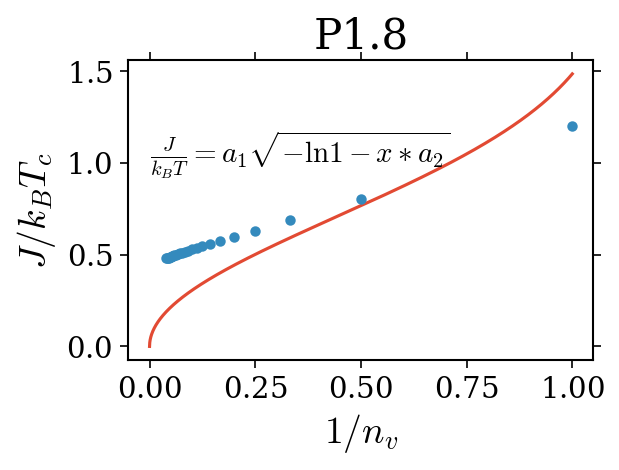

a1: 0.9999999999999999
a2: 0.8901448940086272
Extrapolation:
-0.0 at 1/nv=0
1.4861335739914203 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.820681   0.70946075 0.65678231 0.62631374 0.60561234 0.59096263
 0.57939428 0.57091061 0.56383418 0.55806979 0.55316849 0.54908798
 0.54543032 0.54232349 0.53952593 0.53710364 0.53494708 0.53273731
 0.53099774 0.52942193 0.5279878  0.52667703 0.52540692 0.52416552
 1.19968   ]


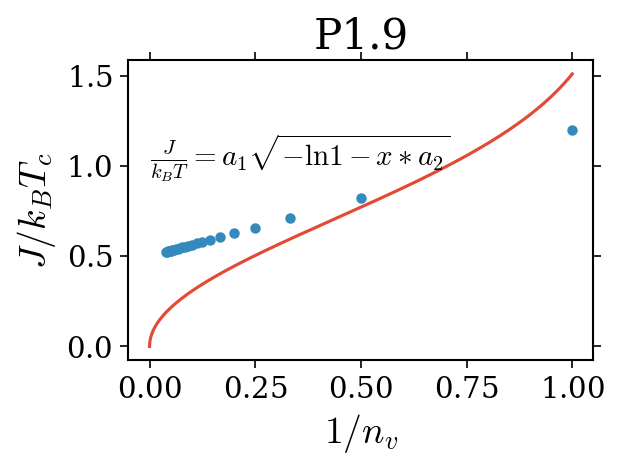

a1: 0.9999999999999999
a2: 0.8981778109526236
Extrapolation:
-0.0 at 1/nv=0
1.5114652597894926 at 1/nv=1
min:-0.0 at 0.0


[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
 0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
 0.07142857 0.06666667 0.0625     0.05882353 0.05555556 0.05263158
 0.05       0.04761905 0.04545454 0.04347826 0.04166667 0.04
 1.        ] [0.83552947 0.7327345  0.68064189 0.65338772 0.63451723 0.62278756
 0.61186669 0.60463742 0.59845052 0.59367749 0.58982855 0.58644893
 0.58352337 0.58124348 0.57917389 0.57705255 0.57548927 0.57412028
 0.57291661 0.57153543 0.57059724 0.56976564 0.56879024 0.56797715
 1.19968   ]


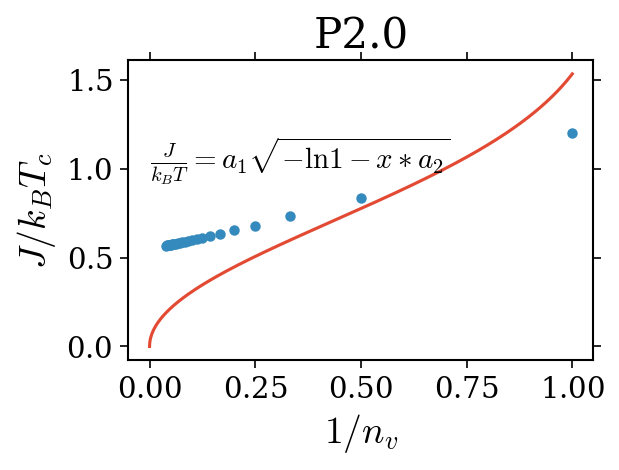

a1: 0.9999999999999999
a2: 0.9049698289480621
Extrapolation:
-0.0 at 1/nv=0
1.5341319525328425 at 1/nv=1
min:-0.0 at 0.0




In [8]:
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_2_parms'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
    if COLUMN == 'P1.0':
        #add value at nv=infty
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)

#     # for square
#     y_data = y_data**2    

    print(x_data,y_data)
    # fit 
    (a1,a2), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[1, 0.5],
                               bounds=([0, 0], [1, 1]))
    df_params[COLUMN] = [a1,a2]
    extrapol_funct = get_extrapol_function(model_function, a1,a2)

    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1 \sqrt{-\ln{1-x*a_2}}$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("a1: {}\na2: {}".format(a1,a2))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")


In [81]:
df_extrapol_val

0.5359269860565828

In [72]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [64]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_5_parms'

In [82]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2     P1.3      P1.4      P1.5      P1.6  \
a1  0.482293  0.477798  0.471745  0.46792  0.464132  0.460553  0.457173   
a2  2.471671  2.296432  2.165874  2.05431  1.962854  1.885828  1.820806   

        P1.7      P1.8      P1.9      P2.0  
a1  0.455118  0.453401  0.452134  0.451736  
a2  1.761702  1.710048  1.664471  1.622459  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_5_parms_params_curves.csv
           P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty  0.000000  0.050731  0.104842  0.161237  0.218332  0.275098  0.330830   
1      1.192069  1.192350  1.192523  1.192993  1.193122  1.192704  1.192621   

           P1.7      P1.8      P1.9      P2.0  
infty  0.385268  0.437720  0.488027  0.535927  
1      1.191817  1.190961  1.190397  1.189137  
Exporting to csv files the extrapolation values

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_5_parms_all_p.png


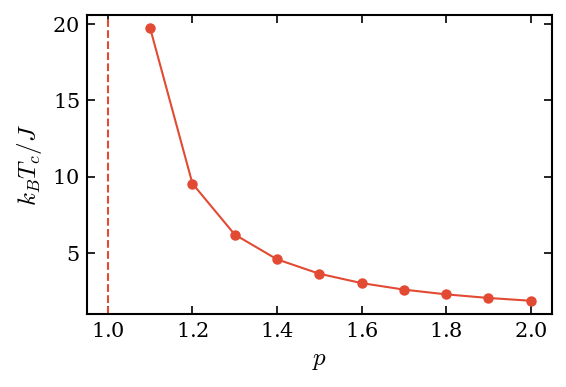

In [78]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()